# R019 : Number of bidders significantly less than average, based on prior similar contracts (for similar item or procuring entity) 

In [4]:
import psycopg2
from psycopg2 import OperationalError
from psycopg2 import sql
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import curve_fit
import seaborn as sns
from IPython.display import HTML
import webbrowser
from collections import defaultdict
import networkx as nx
import csv
import os
from statsmodels.stats.stattools import medcouple 

os.chdir('/home/francisco/MECAD/2º Ano/Estágio/forcera/scripts/scripts_py')



# LIGAÇÃO À BASE DE DADOS
conn = psycopg2.connect(
    host = "contratos-base-gov1.cf87yxnqgph8.eu-central-1.rds.amazonaws.com",
    port = 5432,
    #database = "contratosbasegov",
    user = "contratosbasegov",
    password = "8n9nyeTBFUyCcLJShNrZdPUai2KQkue4")
cur = conn.cursor()

In [20]:
cur.execute('''ROLLBACK;''')

# PARTE 1 

Construir tabela nova : indicadores estatísticos para concursos públicos por CPV

In [3]:
cur = conn.cursor()
cur.execute('''
            SELECT contratos_basegov."id", contratos_basegov."cpv", concursos_publicos."nr_entidadesconcorrentes", cpv_stat."q1", cpv_stat."q2",cpv_stat."q3" 
            FROM contratos_basegov 
            JOIN concursos_publicos ON contratos_basegov."id" = concursos_publicos."id"
            JOIN cpv_stat ON SUBSTRING(contratos_basegov."cpv", 1, 2) = cpv_stat."cpv"
            ORDER BY contratos_basegov."data_publicacao" DESC
            LIMIT 1;
            ''')

for i in cur.fetchall():
    print(i, '\n')

(10565978, '66510000-8', 5, 2.0, 4.0, 6.0) 



In [5]:
# Dataframe com CPV(2 digitos), ID e NR_entidadesconcorrentes
cur = conn.cursor()
cur.execute('''
                SELECT cpv2, concursospublicos."id", nr_entidadesconcorrentes
                FROM concursospublicos
                ORDER BY cpv2 DESC;''')

data = pd.DataFrame(cur.fetchall())

## Parte 1.1 : Plot da distribuição de NEC

In [6]:
data = data.rename(columns={0:'cpv', 1:'id', 2:'nec'})

In [5]:
data_sorted = data.sort_values(by=['nec'], ascending=[False])

/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/francisco/MECAD/COMP/comp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future

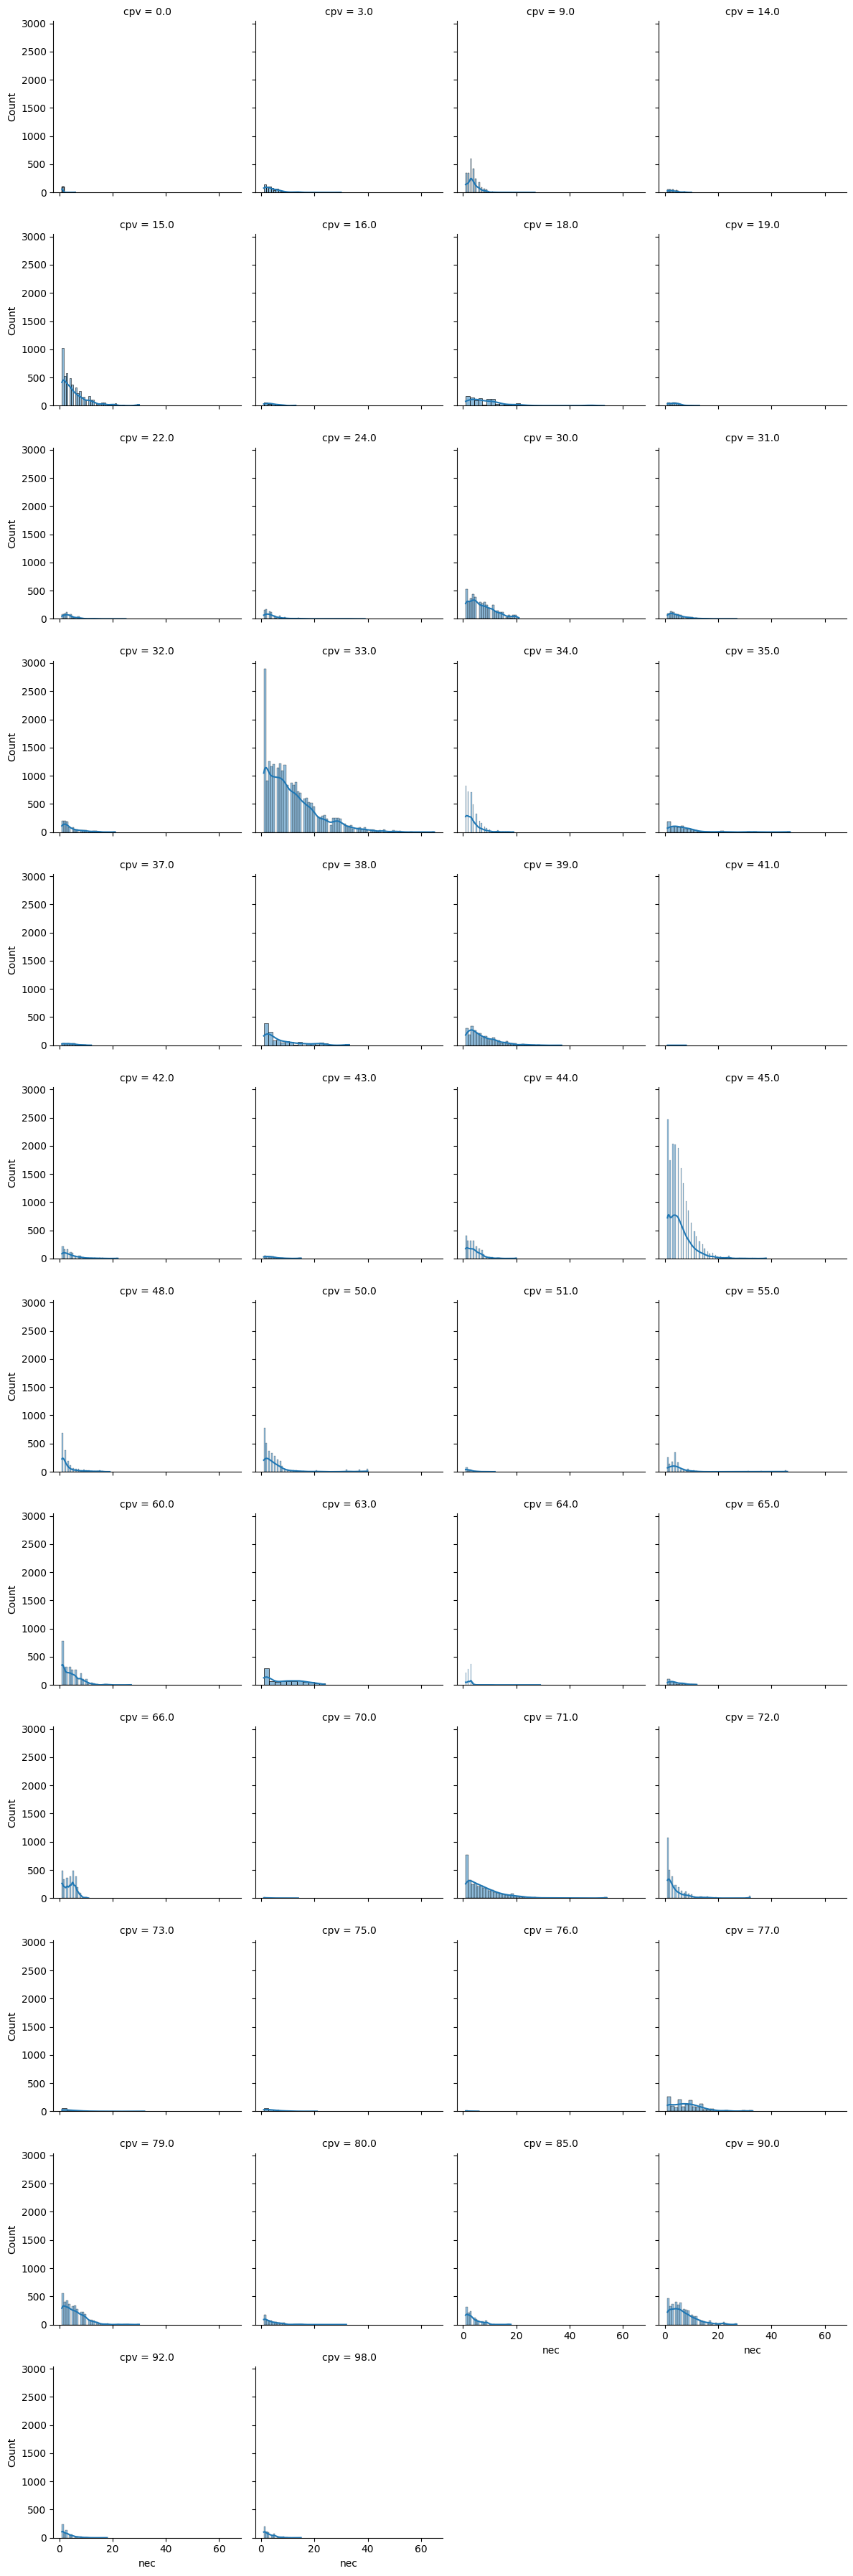

In [193]:
g = sns.FacetGrid(data=data_sorted, col='cpv', col_wrap=4)
g.map(sns.histplot, 'nec', kde = True)
plt.show()

In [6]:
data1 = data[data["cpv"] != 0]

In [10]:
CPV = data.iloc[:,0]

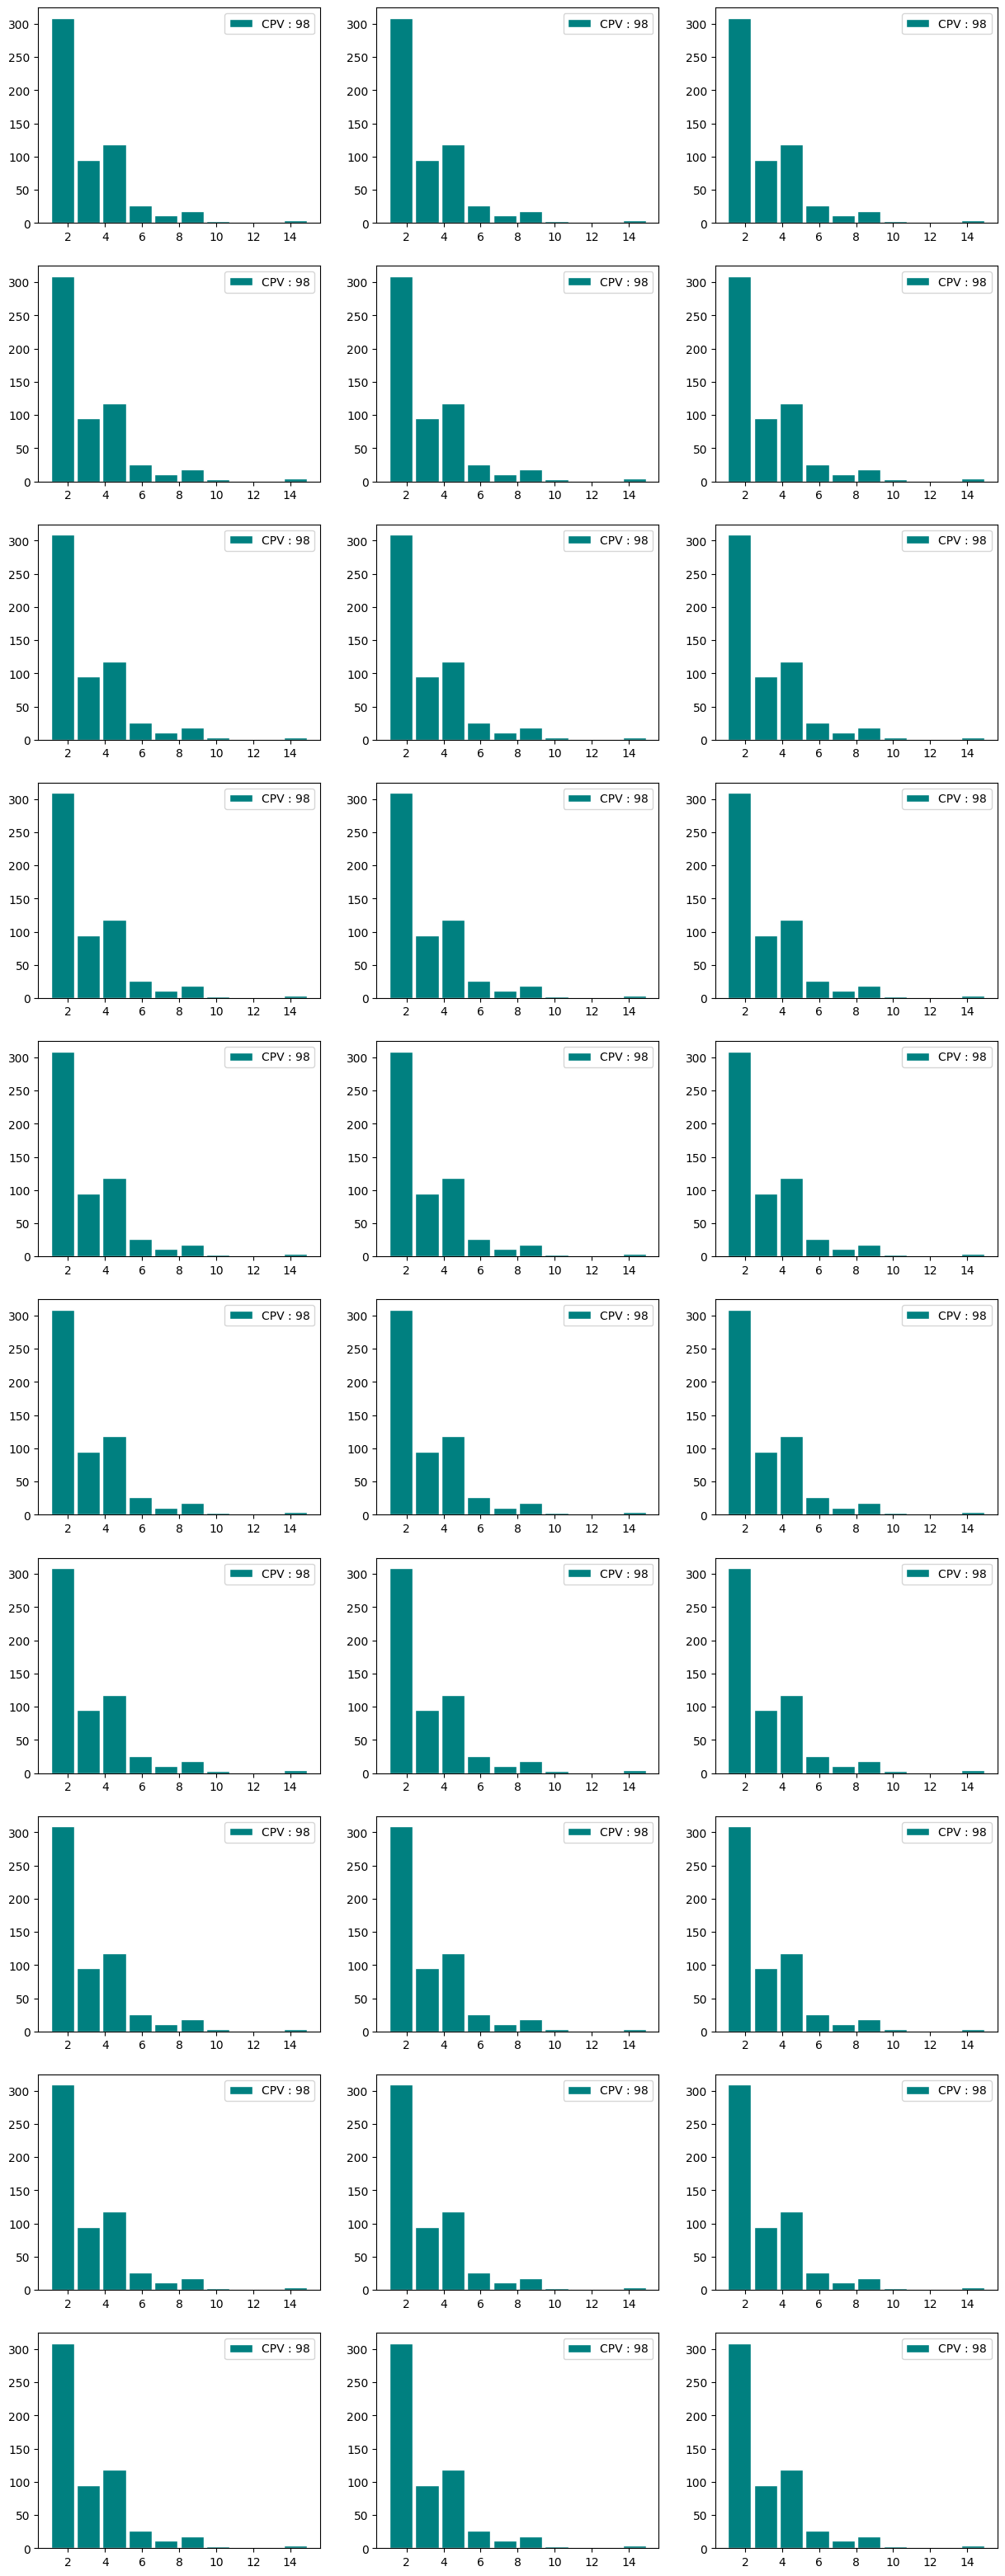

In [9]:
figure, axis = plt.subplots(10, 3, figsize=(15,40))

counter = 0

for i in range(10):
    for j in range(3):

        ax = axis[i][j]
        df = data.loc[data["cpv"] == CPV[counter], "nec"]
        ax.hist(df, edgecolor='white', color='teal', rwidth=0.9, label = 'CPV : ' + str(int(CPV[counter])))
        counter += 1
        ax.legend(loc = 'best')

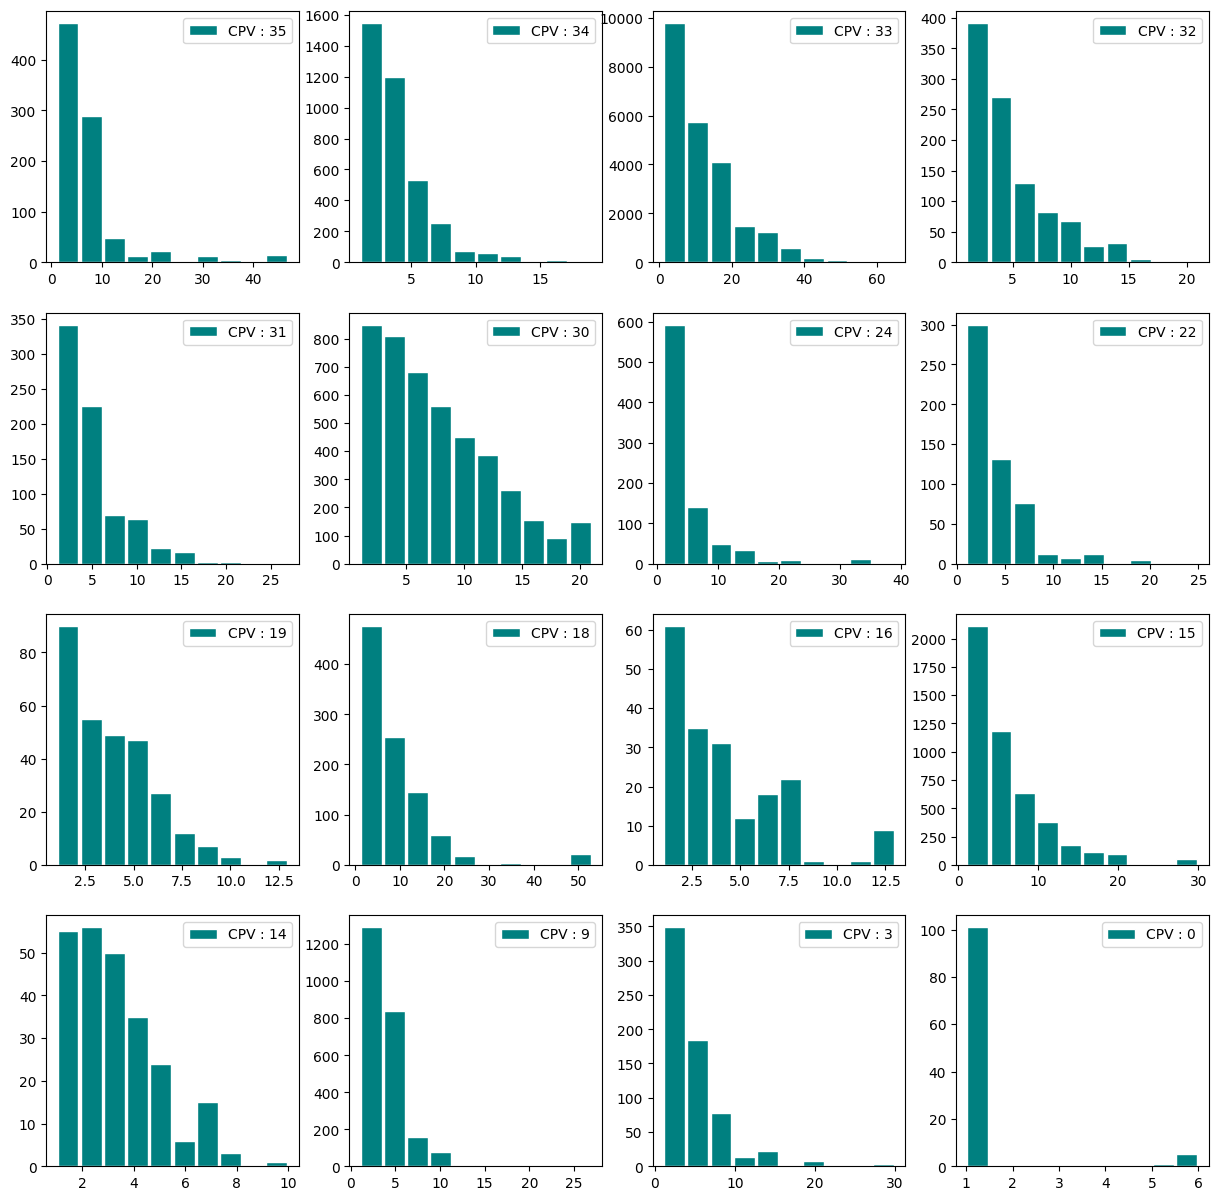

In [226]:
figure, axis = plt.subplots(4,4, figsize=(15,15))

counter = 30

for i in range(4):
    for j in range(4):

        ax = axis[i][j]
        df = data.loc[data["cpv"] == CPV[counter], "nec"]
        ax.hist(df, edgecolor='white', color='teal', rwidth=0.9, label = 'CPV : ' + str(int(CPV[counter])))
        counter += 1
        ax.legend(loc = 'best')

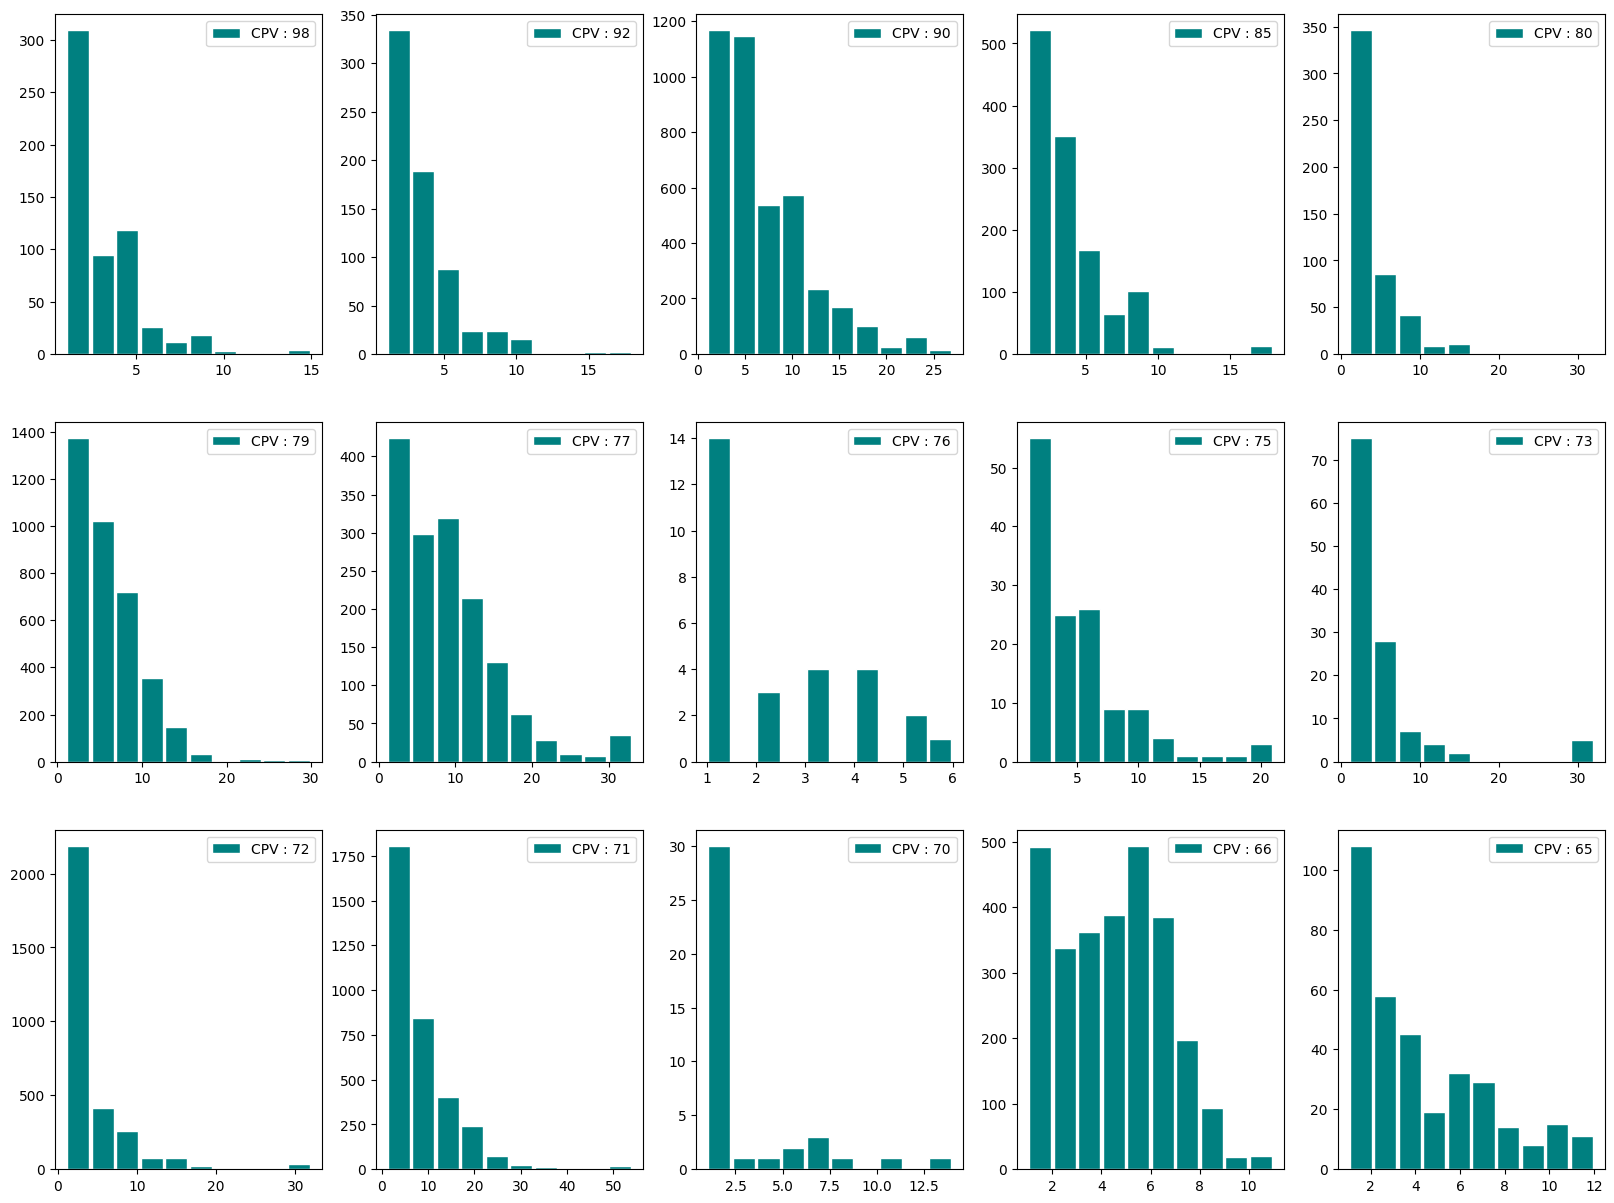

In [245]:
figure, axis = plt.subplots(3, 5, figsize=(20,15))

counter = 0

for i in range(3):
    for j in range(5):

        ax = axis[i][j]
        df = data1.loc[data1["cpv"] == CPV[counter], "nec"]
        ax.hist(df, edgecolor='white', color='teal', rwidth=0.9, label = 'CPV : ' + str(int(CPV[counter])))
        counter += 1
        ax.legend(loc = 'best')

#plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/r019_hist1.png',dpi = 500 ,bbox_inches='tight')
plt.show()

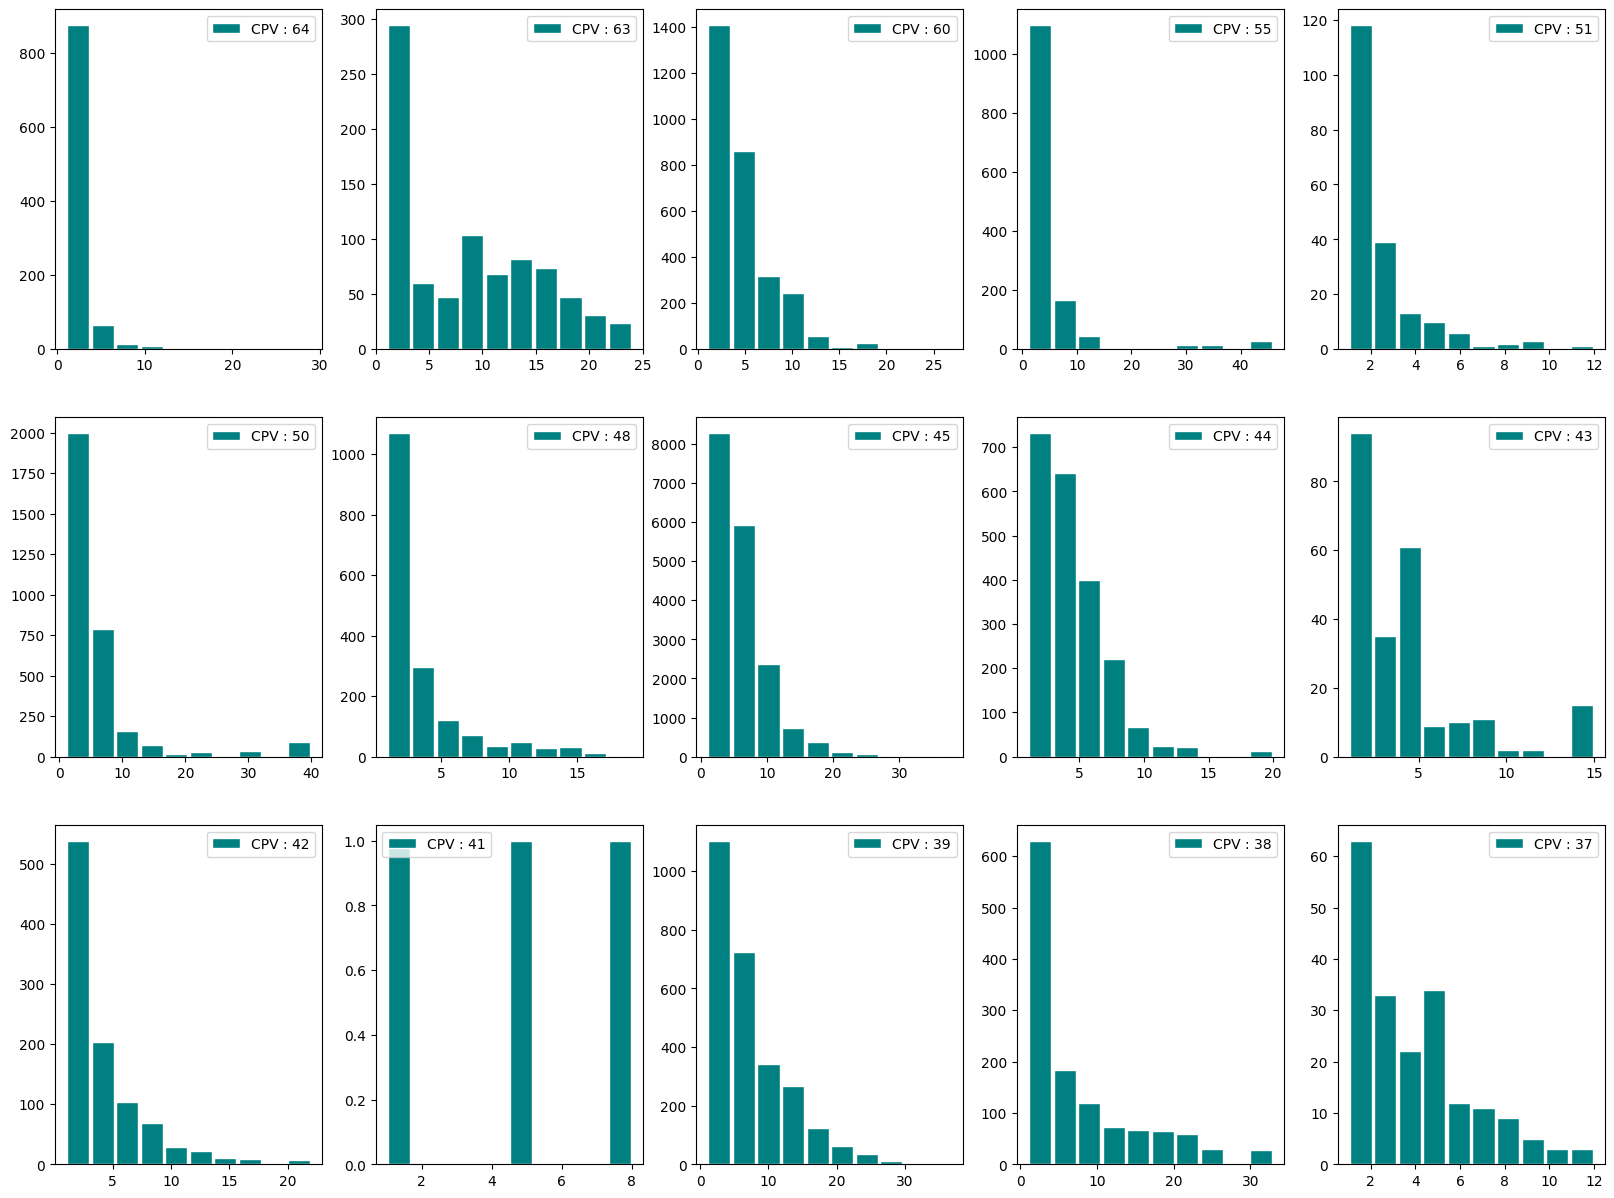

In [249]:
figure, axis = plt.subplots(3, 5, figsize=(20,15))

counter = 15

for i in range(3):
    for j in range(5):

        ax = axis[i][j]
        df = data1.loc[data1["cpv"] == CPV[counter], "nec"]
        ax.hist(df, edgecolor='white', color='teal', rwidth=0.9, label = 'CPV : ' + str(int(CPV[counter])))
        counter += 1
        ax.legend(loc = 'best')

#plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/r019_hist2.png',dpi = 500 ,bbox_inches='tight')
plt.show()

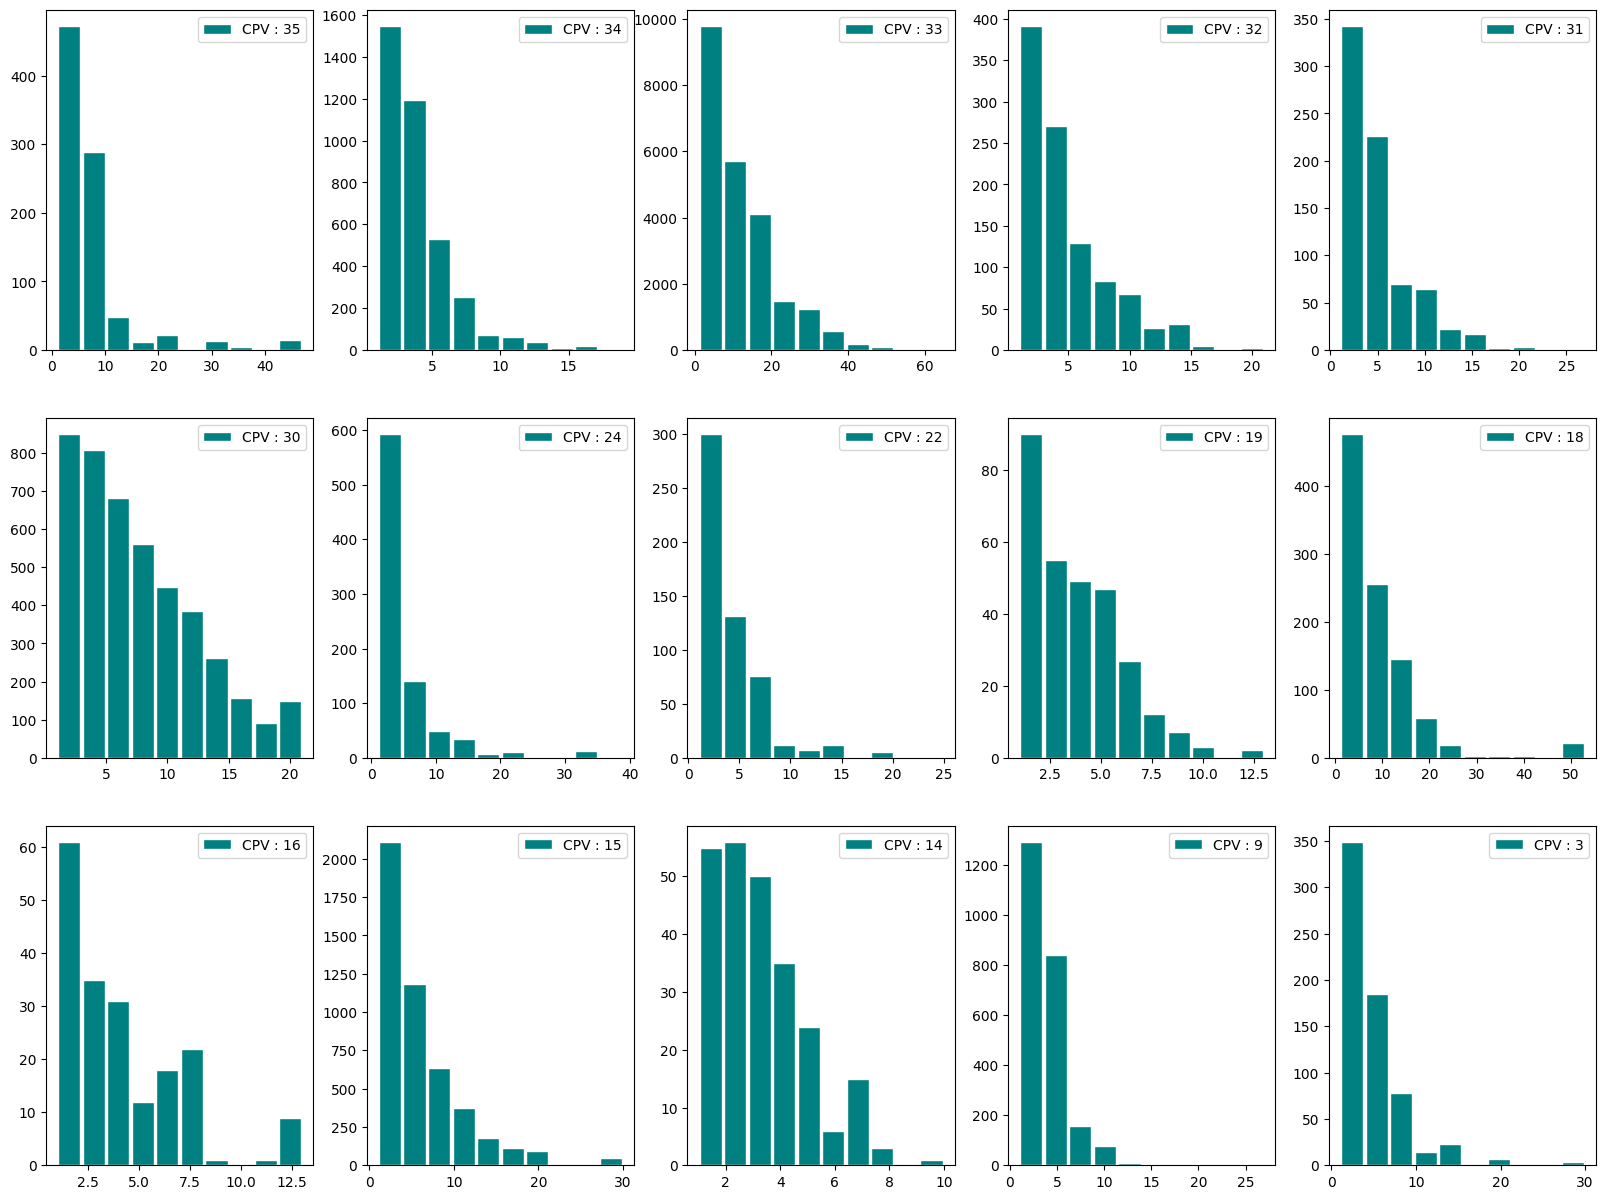

In [248]:
figure, axis = plt.subplots(3, 5, figsize=(20,15))

counter = 30

for i in range(3):
    for j in range(5):

        ax = axis[i][j]
        df = data1.loc[data1["cpv"] == CPV[counter], "nec"]
        ax.hist(df, edgecolor='white', color='teal', rwidth=0.9, label = 'CPV : ' + str(int(CPV[counter])))
        counter += 1
        ax.legend(loc = 'best')

#plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/r019_hist3.png',dpi = 500 ,bbox_inches='tight')
plt.show()

## Parte 1.2 : Cálculo Indicadores Estatísticos

In [117]:
m = np.zeros([len(CPV),10])
m[:,0] = CPV

for i,j in enumerate(CPV):
    
    res = data.loc[data.iloc[:,0] == j ,data.columns[2]]
    m[i,1] = res.values.sum()
    m[i,2:] = list(res.describe())

In [181]:
table_name = 'cpv_stat'
column_names = ['cpv', 'nec_t', 'count', 'mean', 'std', 'min', 'q1', 'q2', 'q3', 'max']


# Correr apenas uma vez. Caso contrário, adiciona linhas com a mesma info

#for row in m:
#    insert_query = sql.SQL("INSERT INTO {} ({}) VALUES ({});").format(
#        sql.Identifier(table_name),
#        sql.SQL(',').join(sql.Identifier(name) for name in column_names),
#        sql.SQL(',').join(sql.Literal(value) for value in row)
#    )
#    cur.execute(insert_query)

conn.commit()

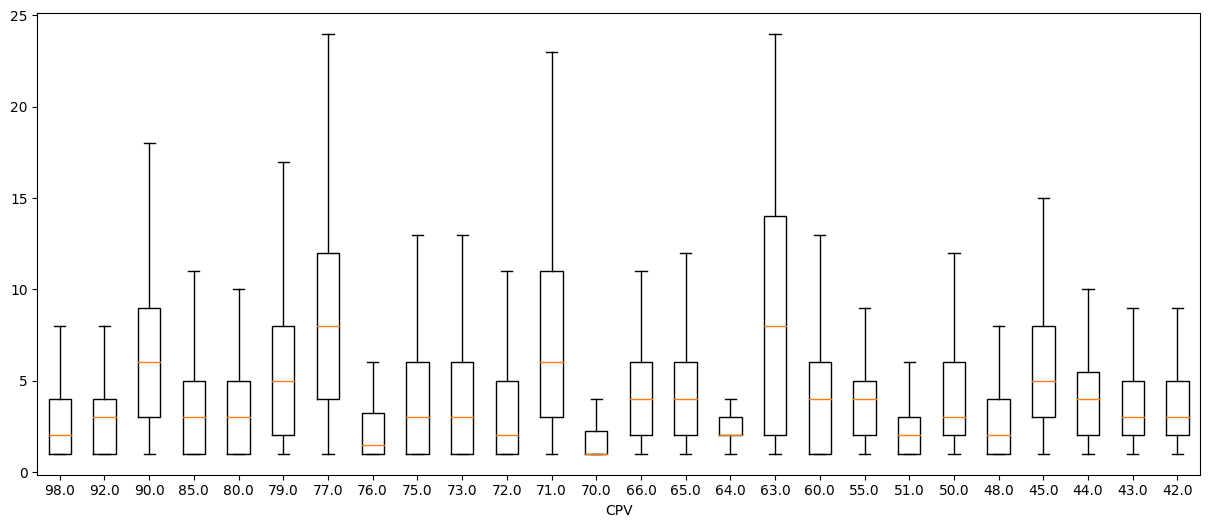

In [64]:
plt.figure(figsize=(15,6))
res1 = [data.loc[data[data.columns[0]] == c, data.columns[2]].values for c in CPV[0:26]]
plt.boxplot(res1, showfliers=False, labels=CPV[0:26])

plt.xlabel('CPV')
#plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/cpv1.png', dpi = 400, bbox_inches='tight')
plt.show()

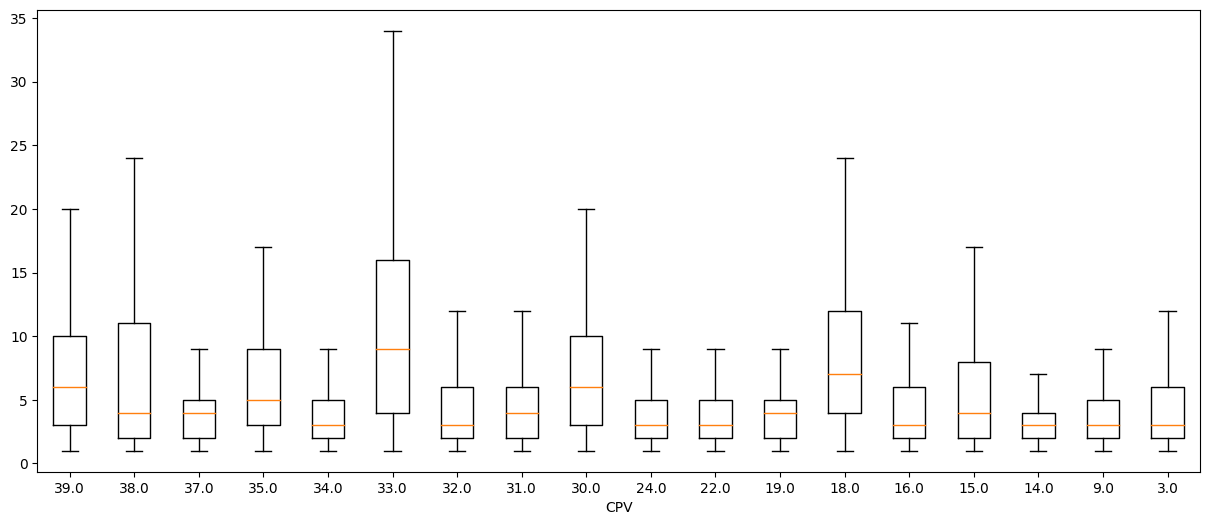

In [7]:
plt.figure(figsize=(15,6))
res1 = [data.loc[data[data.columns[0]] == c, data.columns[2]].values for c in CPV[27:-1]]
plt.boxplot(res1, showfliers=False, labels=CPV[27:-1])

plt.xlabel('CPV')
plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/cpv2.png', dpi = 400, bbox_inches='tight')
plt.show()

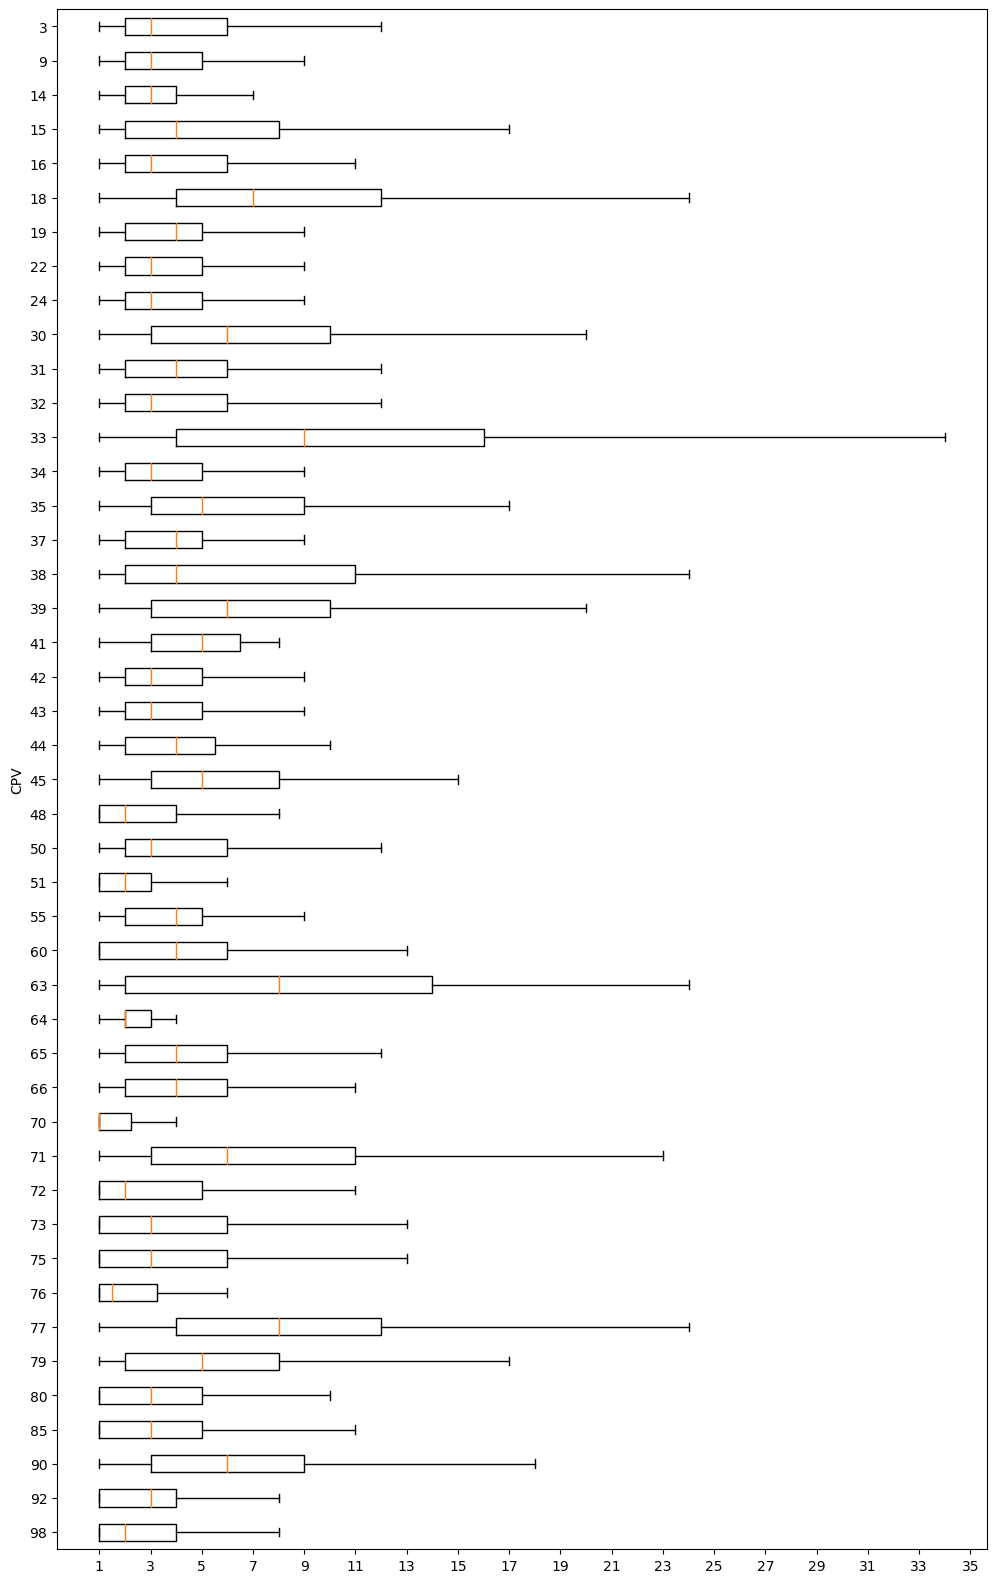

In [254]:
#meds = df2.median()
#meds.sort_values(ascending=False, inplace=True)
#df2 = df2[meds.index]
#df2.boxplot()


plt.figure(figsize=(12,20))
res1 = [data.loc[data[data.columns[0]] == c, data.columns[2]].values for c in CPV[0:-1].astype(int)]

plt.boxplot(res1, showfliers=False, labels=CPV[0:-1].astype(int), vert=False)

plt.ylabel('CPV')
plt.xticks(np.arange(1,36,2))
#plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/cpv3.png', dpi = 400, bbox_inches='tight')

plt.show()

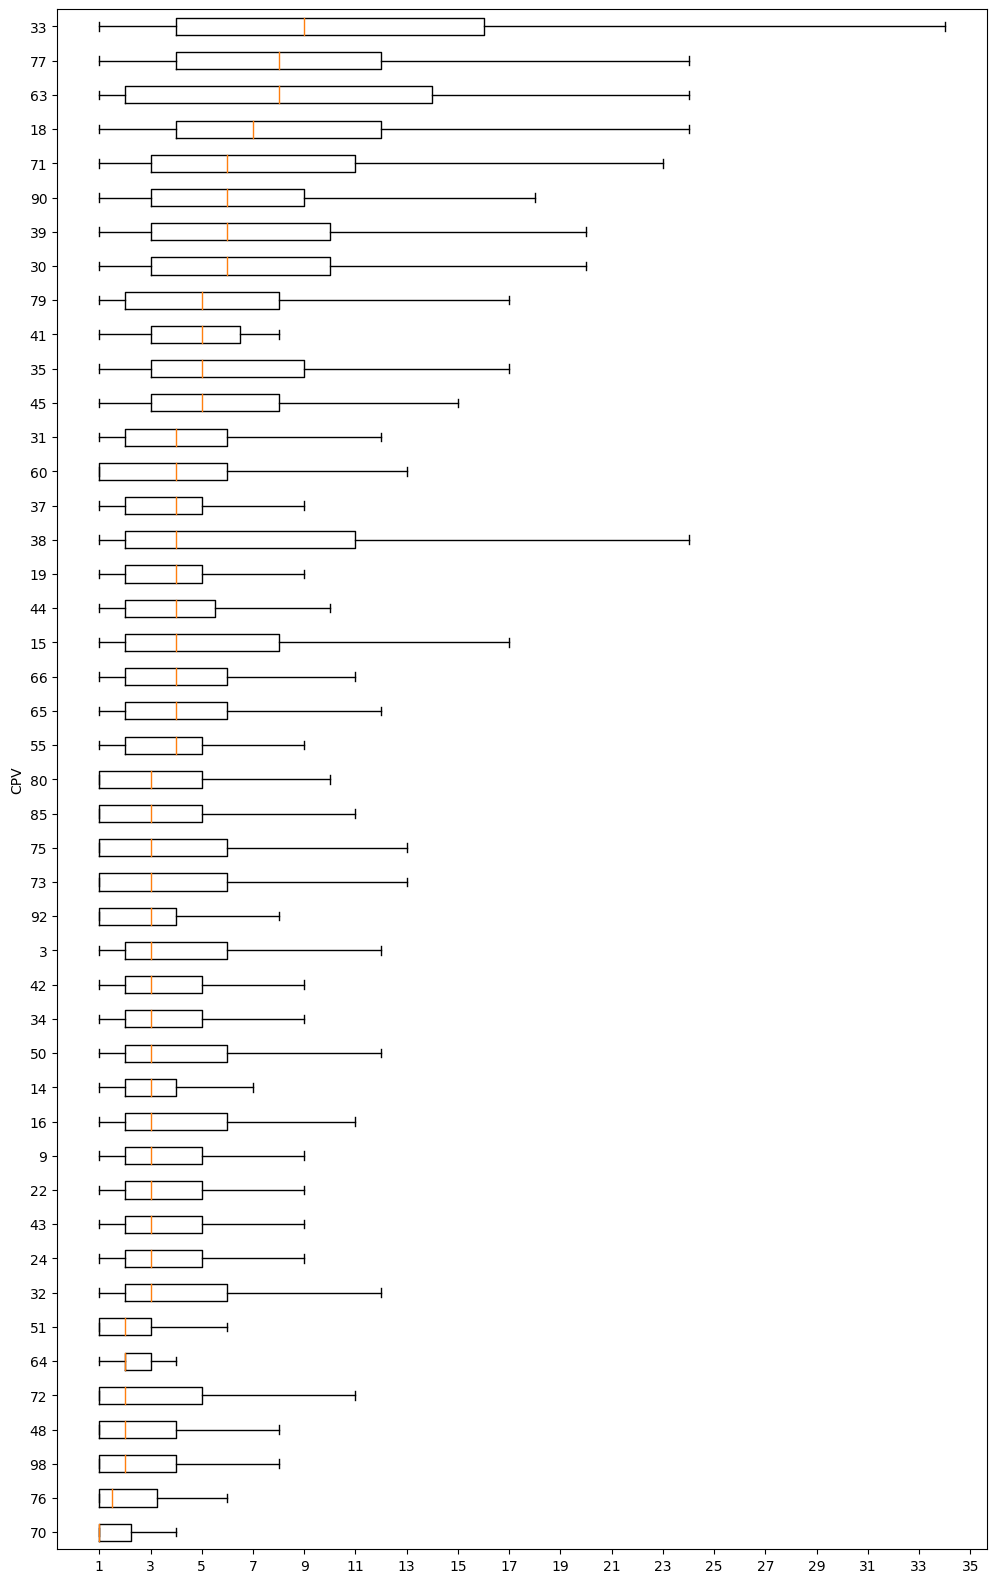

In [255]:
# Calculate medians for each CPV category
medians = [np.median(arr) for arr in res1]

# Sort CPV categories based on medians
sorted_indices = np.argsort(medians)

# Sort res1 and CPV accordingly
sorted_res1 = [res1[i] for i in sorted_indices]
sorted_CPV = CPV[sorted_indices].astype(int)

# Create the boxplot
plt.figure(figsize=(12, 20))
plt.boxplot(sorted_res1, showfliers=False, labels=sorted_CPV, vert=False)

plt.ylabel('CPV')
plt.xticks(np.arange(1, 36, 2))

# Show or save the plot
plt.show()

# PARTE 2 

Construir nova tabela com indicadores estatísticos para concursos públicos por CPV e por tipo de contrato

Tipo de contrato tem 3 categorias : 
- Bens e Serviços
- Empreitadas
- Outro

Formato tabela :

- CPV | TipoContrato | NEC Total | NºConcursos | Indicadores Estatísticos

In [194]:
cur = conn.cursor()
cur.execute('''
            SELECT cpv2, tipocontrato, nr_entidadesconcorrentes
            FROM concursospublicos
            ORDER BY cpv2 DESC;
            ''')

data1 = pd.DataFrame(cur.fetchall())

In [195]:
# CONJUNTO DE CPV's
cpv = (data1.iloc[:,0].unique())
cpv

array(['98', '92', '90', '85', '80', '79', '77', '76', '75', '73', '72',
       '71', '70', '66', '65', '64', '63', '60', '55', '51', '50', '48',
       '45', '44', '43', '42', '41', '39', '38', '37', '35', '34', '33',
       '32', '31', '30', '24', '22', '19', '18', '16', '15', '14', '09',
       '03', '00'], dtype=object)

In [208]:
#TIPOS DE CONTRATO
tc = data1.iloc[:,1].unique()
tc

array(['Bens e Serviços', 'Empreitadas', 'Outro'], dtype=object)

In [215]:
# data.loc[data.iloc[:,0] == j ,data.columns[2]]

#data1.loc[data1.iloc[:,0] == '98', data1.iloc[:,1] == 'Bens e Serviços', data.columns[2]]
data1.loc[(data1.iloc[:, 0] == '98') & (data1.iloc[:, 1] == 'Bens e Serviços'), data1.columns[2]].values.sum()


1723

In [249]:
Mm = np.zeros([len(cpv)*3,11], dtype=object)

cpv_rep = np.repeat(cpv,3)
Mm[:,0] = cpv_rep

for i in range(0,len(cpv_rep),3):
    for j in range(3):
        
        Mm[i+j,1] = tc[j]
        
        res = data1.loc[(data1.iloc[:, 0] == cpv_rep[i]) & (data1.iloc[:, 1] == tc[j]), data1.columns[2]]
        
        Mm[i+j,2] = res.values.sum()
        Mm[i+j,3:] = res.describe()


In [268]:
table_name = 'cpv_stat1'
column_names = ['cpv', 'tipocontrato', 'nec_t', 'count', 'mean', 'std', 'min', 'q1', 'q2', 'q3', 'max']


# Correr apenas uma vez. Caso contrário, adiciona linhas com a mesma info
for row in Mm:
    insert_query = sql.SQL("INSERT INTO {} ({}) VALUES ({});").format(
        sql.Identifier(table_name),
        sql.SQL(',').join(sql.Identifier(name) for name in column_names),
        sql.SQL(',').join(sql.Literal(int(value)) if isinstance(value, np.int64) else sql.Literal(value) for value in row)
    )
    cur.execute(insert_query)

conn.commit()

In [275]:
data1.rename(columns={0:'CPV', 1:'Tipo de Contrato', 2:'Values'}, inplace=True)

In [276]:
data1

,CPV,Tipo de Contrato,Values
0,98,Bens e Serviços,1
1,98,Bens e Serviços,5
2,98,Bens e Serviços,1
3,98,Bens e Serviços,2
4,98,Bens e Serviços,4
...,...,...,...
103711,00,Outro,1
103712,00,Outro,1
103713,00,Outro,1
103714,00,Outro,1


In [287]:
res1 = [[data1.loc[(data1['CPV'] == c) & (data1['Tipo de Contrato'] == cc), 'Values'].values for cc in tc] for c in cpv_rep].size > 20
res1

AttributeError: 'list' object has no attribute 'size'

In [286]:
data1

,CPV,Tipo de Contrato,Values
0,98,Bens e Serviços,1
1,98,Bens e Serviços,5
2,98,Bens e Serviços,1
3,98,Bens e Serviços,2
4,98,Bens e Serviços,4
...,...,...,...
103711,00,Outro,1
103712,00,Outro,1
103713,00,Outro,1
103714,00,Outro,1


# PARTE 3

Plots para comparar média, std e mediana por CPV

In [66]:
cur = conn.cursor()
cur.execute('''
                SELECT *
                FROM cpv_stat;''')

tabela = pd.DataFrame(cur.fetchall())

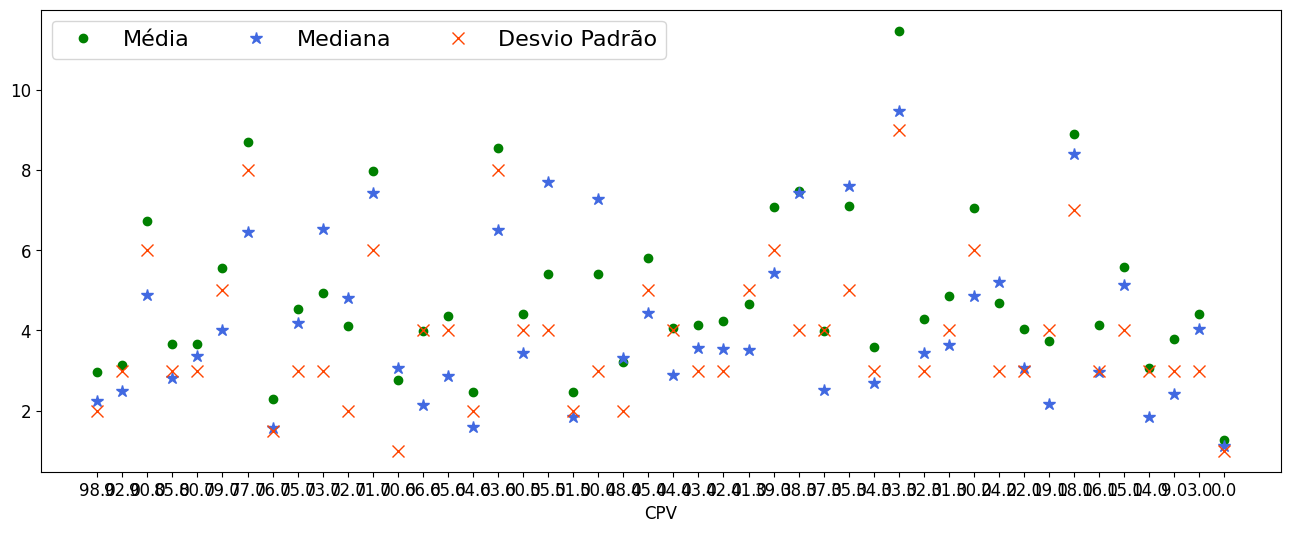

In [67]:
plt.figure(figsize=(16,6))


for i in range(len(tabela)):
    
    cpv = tabela.iloc[i, tabela.columns[0]]
    media = tabela.iloc[i, tabela.columns[3]]
    mediana = tabela.iloc[i, tabela.columns[4]]
    std = tabela.iloc[i, tabela.columns[7]]

    plt.plot(i, media, 'o', color='green', ms = 6, label=f'{cpv}')
    plt.plot(i, mediana, '*', color='royalblue', ms = 9)
    plt.plot(i, std, 'x', color='orangered', ms = 9)

plt.legend(loc='best', labels=['Média', 'Mediana', 'Desvio Padrão'], ncol = 3, fontsize = 16)
plt.xticks(np.arange(len(tabela)), CPV, rotation=0, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('CPV', fontsize = 12)

#plt.savefig('/home/francisco/MECAD/2º Ano/Estágio/tese/tese_pt/imagens/mmdp.png', dpi = 400, bbox_inches='tight')

plt.show()

# Parte 4 : Adaptação da fence

- Guardar num array as 46 categorias de 2 dígitos do CPV

In [7]:
cur = conn.cursor()

cur.execute('''
                SELECT SUBSTRING(cpv,1,2)
                FROM contratos_basegov
            ''')

cpv_xx = pd.DataFrame(item[0] for item in cur.fetchall())

In [8]:
cpvXX = cpv_xx.iloc[:,0].unique()

In [9]:
cpvXX

array(['22', '34', '55', '72', '79', '98', '33', '65', '80', '75', '32',
       '50', '92', '90', '44', '30', '45', '31', '60', '15', '09', '48',
       '39', '71', '85', '42', '24', '77', '63', '66', '51', '38', '73',
       '37', '64', '70', '03', '16', '35', '19', '18', '14', '43', '76',
       '41', ''], dtype=object)

In [34]:
mc_values = list()

cur = conn.cursor()

for i in (cpvXX[:-1]).astype(int):

    df = data.loc[data["cpv"] == i, "nec"].values

    if len(df) < 10000:

        const = float(medcouple(df))
        mc_values.append([i, const])
       
        cur.execute('''
                    UPDATE cpv_stat SET medcouple_constant = %s WHERE cpv_stat."cpv" = %s;
                   ''', (const, str(i)))
                    

conn.commit()

In [26]:
valores_add = list()

cur = conn.cursor()

for i in (cpvXX[:-1]).astype(int):

    cur.execute('''
                SELECT q1, q3, dq, medcouple_constant
                FROM cpv_stat
                WHERE cpv_stat."cpv" = %s;
               ''', (str(i),))
    
    q1,q3,iqr,mc =(cur.fetchall()[0])
    
    if mc != None: 
        lf = q1 - 1.5*np.exp(-4*mc)*iqr
        uf = q3 + 1.5*np.exp(3*mc)*iqr

        valores_add.append([i,lf,uf])
        

    else :
        lf = q1 - 1.5*iqr
        uf = q3 + 1.5*iqr

        valores_add.append([i,lf,uf])

conn.commit()

DatabaseError: SSL SYSCALL error: Success


In [21]:
cur = conn.cursor()

for i in valores_add:
    cpv, lf, uf = i

    cur.execute('''
                UPDATE cpv_stat
                SET lower_fence = %s, upper_fence = %s
                WHERE cpv_stat."cpv" = %s;
                ''', (lf, uf, str(cpv)))

conn.commit()

In [25]:
type(cpvXX[0])

str